## Compare trace aligments

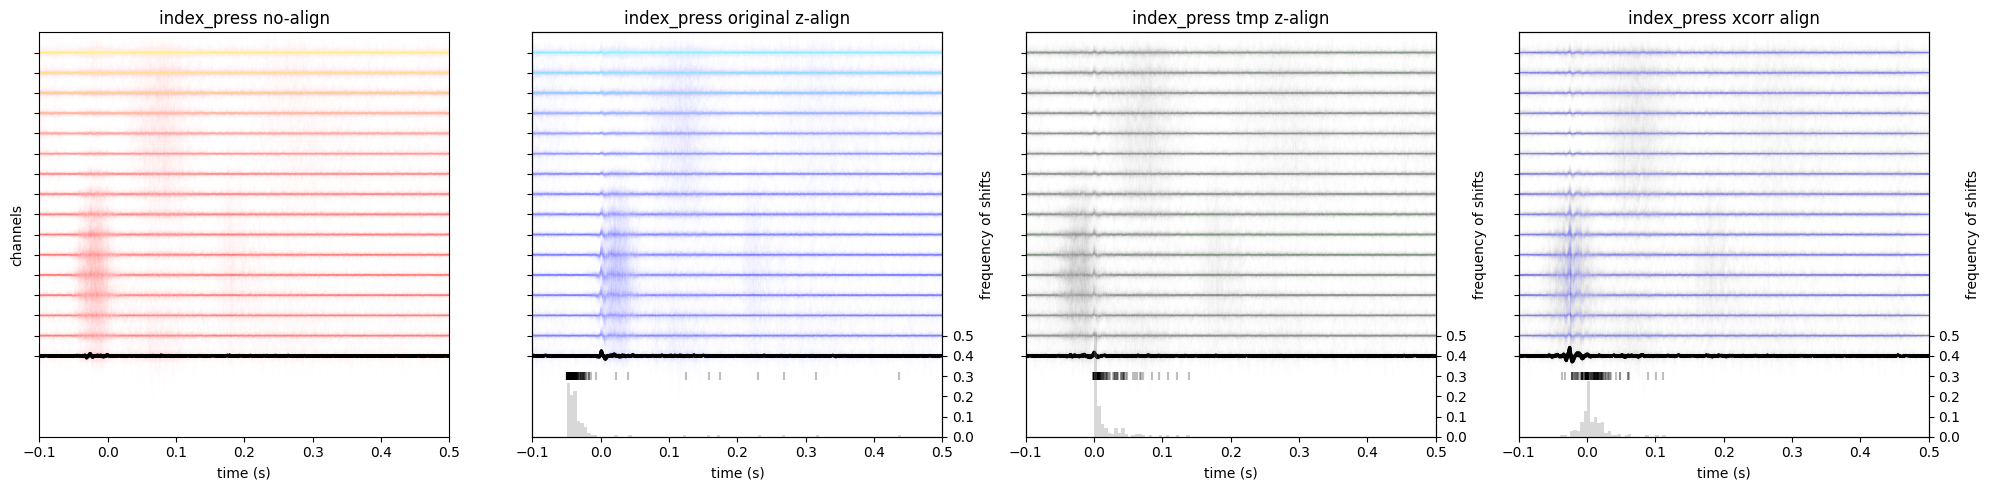

gesture     mode    n  mean_corr_to_ref  mean_std_over_time
0  index_press  noalign  150          0.072101            1.166719
1  index_press   orig_z  150          0.115172            1.177556
2  index_press    tmp_z  145          0.097027            1.197743
3  index_press    xcorr  150          0.185691            1.158764

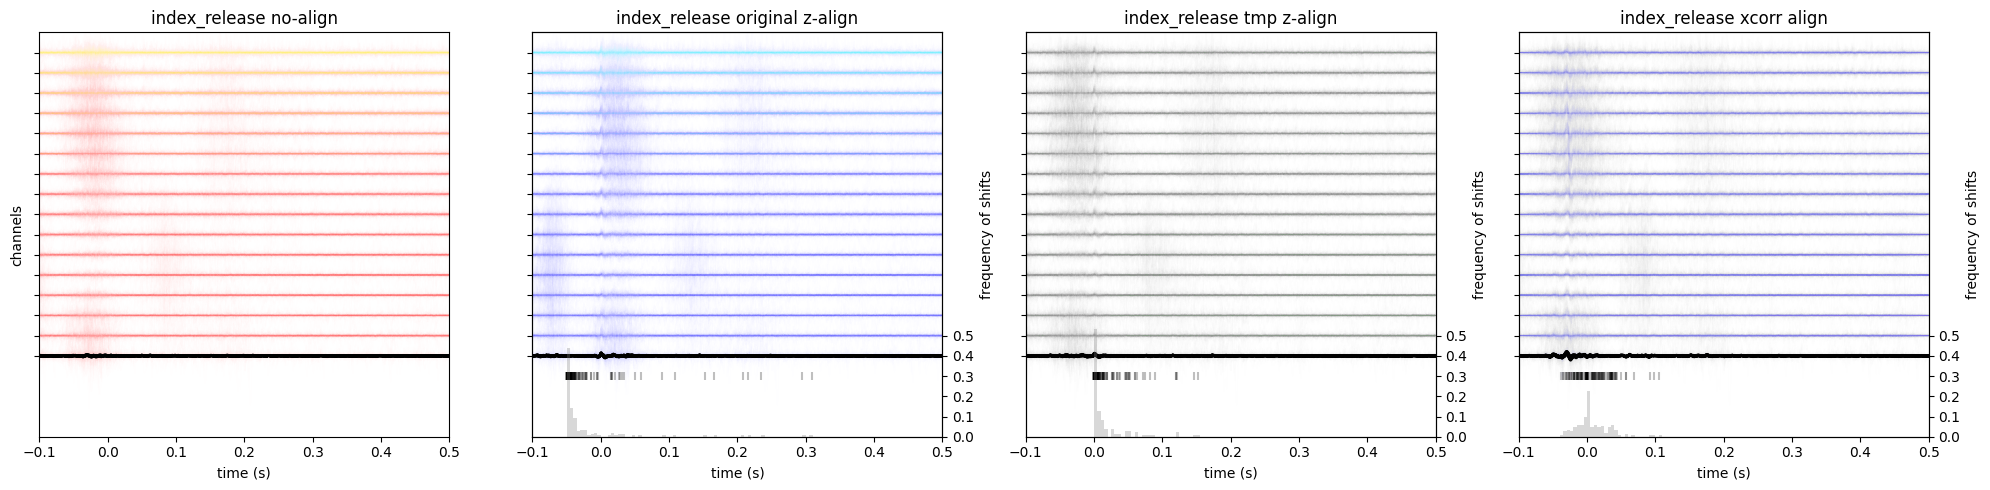

gesture     mode    n  mean_corr_to_ref  mean_std_over_time
0  index_release  noalign  150          0.067809            1.070181
1  index_release   orig_z  150          0.105245            1.143530
2  index_release    tmp_z  133          0.094260            1.130680
3  index_release    xcorr  150          0.176572            1.056704

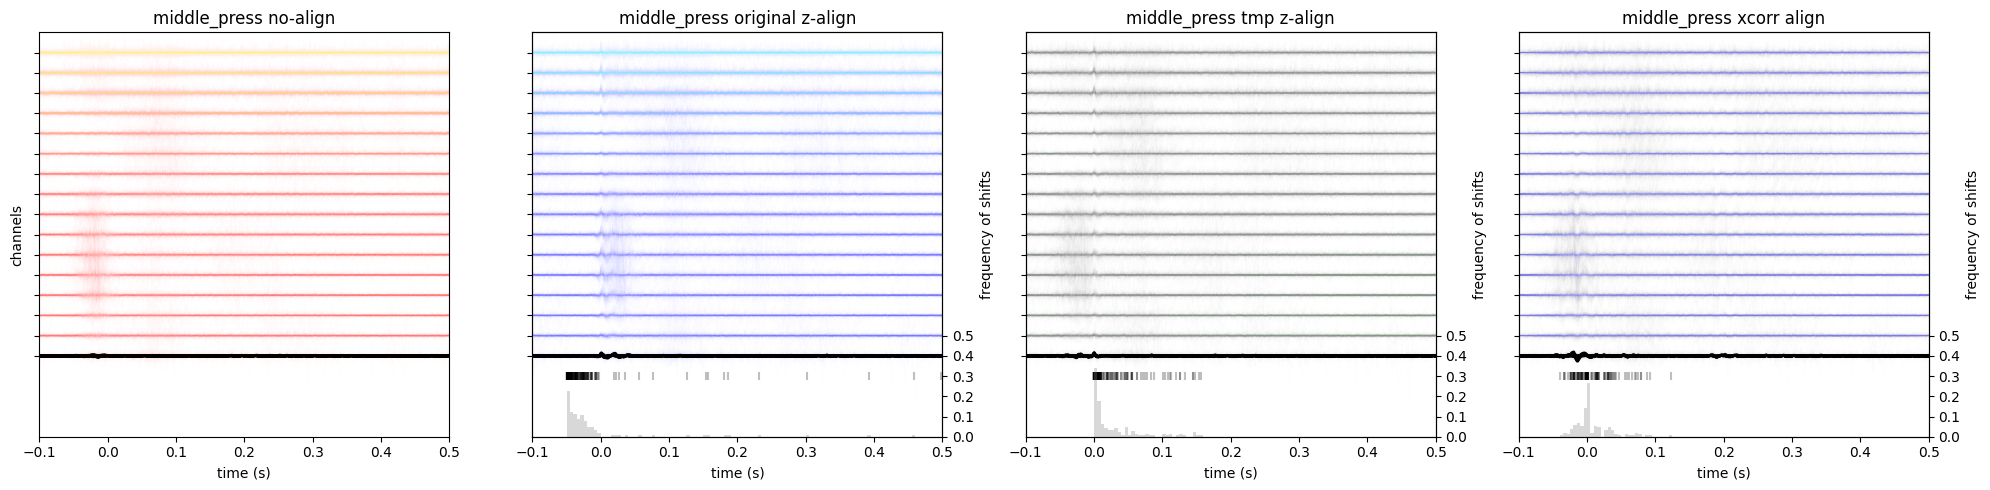

gesture     mode    n  mean_corr_to_ref  mean_std_over_time
0  middle_press  noalign  150          0.067812            0.961929
1  middle_press   orig_z  150          0.108648            0.989327
2  middle_press    tmp_z  142          0.097139            0.990869
3  middle_press    xcorr  150          0.143651            0.954199

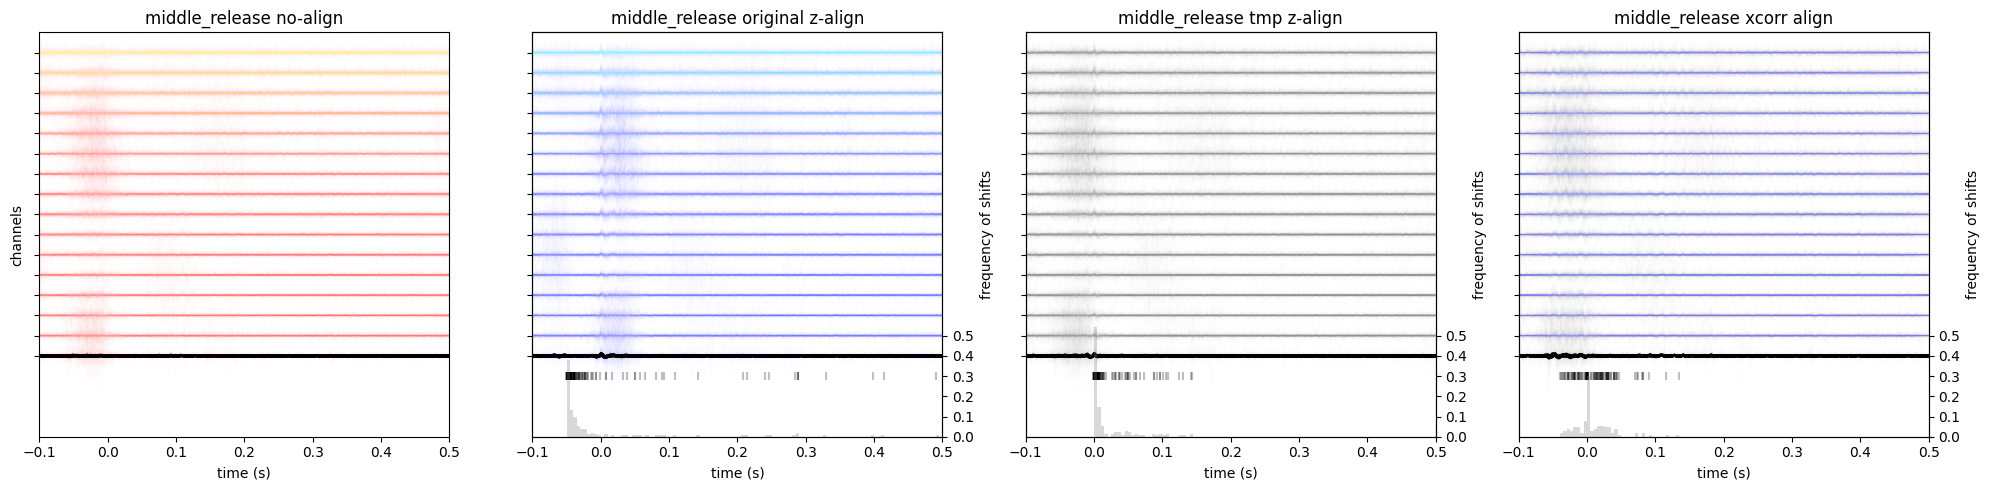

gesture     mode    n  mean_corr_to_ref  mean_std_over_time
0  middle_release  noalign  150          0.065386            0.922163
1  middle_release   orig_z  150          0.103681            0.959979
2  middle_release    tmp_z  135          0.086980            0.960000
3  middle_release    xcorr  150          0.146995            0.917491

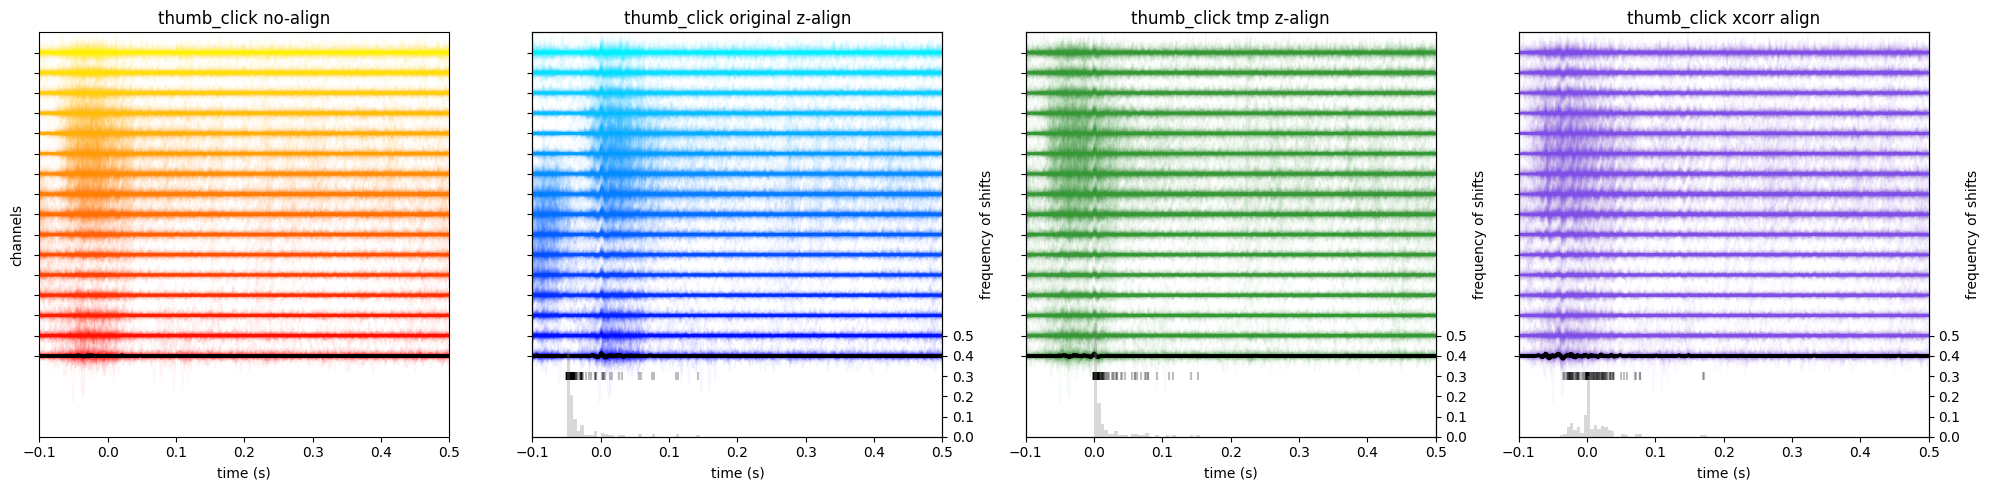

gesture     mode    n  mean_corr_to_ref  mean_std_over_time
0  thumb_click  noalign  150          0.073933            1.017223
1  thumb_click   orig_z  150          0.112841            1.056822
2  thumb_click    tmp_z  144          0.106941            1.036030
3  thumb_click    xcorr  150          0.160334            1.007716

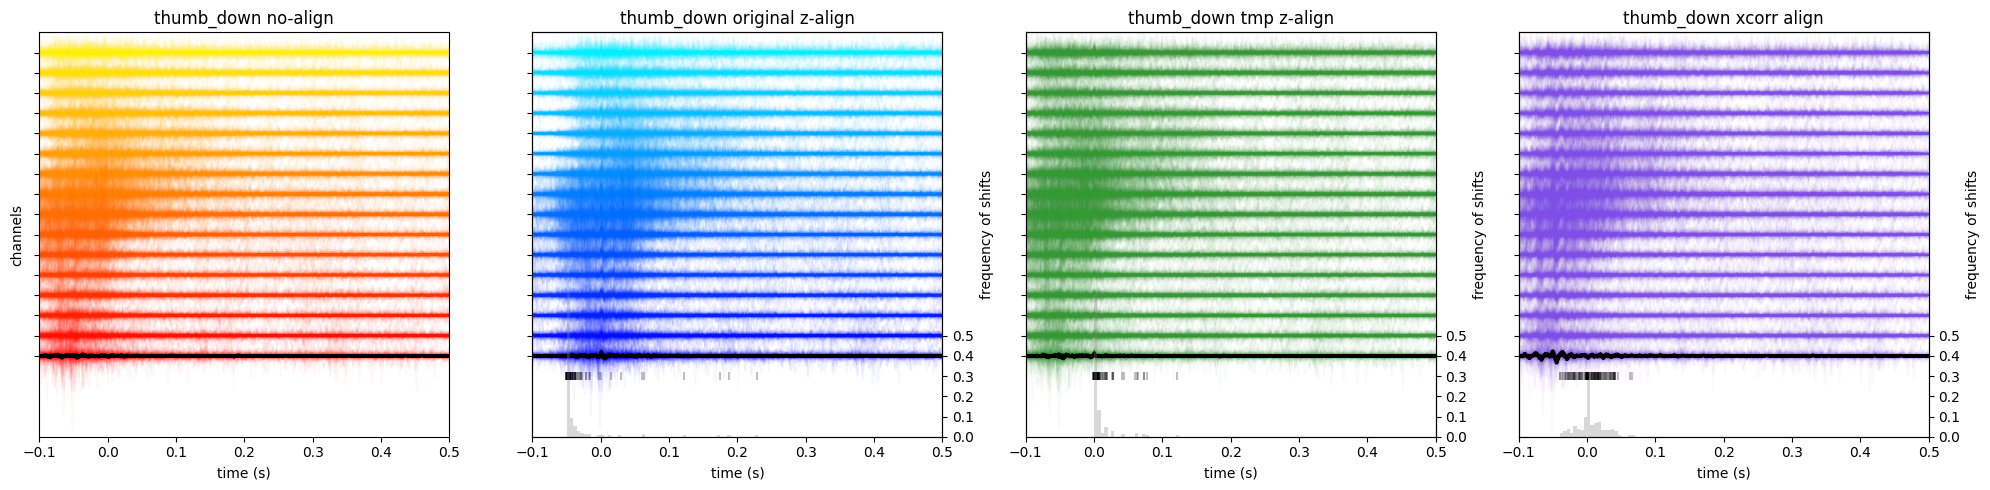

gesture     mode    n  mean_corr_to_ref  mean_std_over_time
0  thumb_down  noalign  150          0.079321            1.345531
1  thumb_down   orig_z  150          0.091763            1.365277
2  thumb_down    tmp_z  149          0.084436            1.347278
3  thumb_down    xcorr  150          0.172596            1.320068

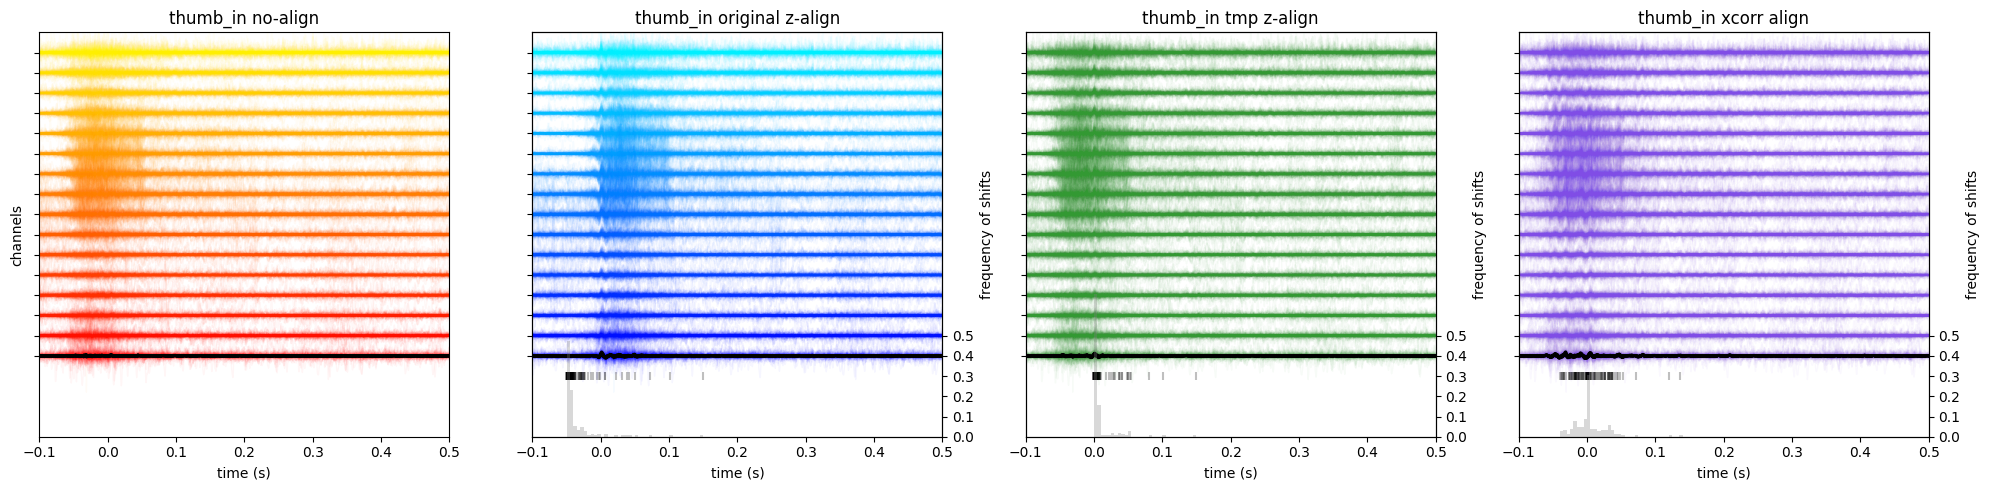

gesture     mode    n  mean_corr_to_ref  mean_std_over_time
0  thumb_in  noalign  150          0.069214            1.059871
1  thumb_in   orig_z  150          0.101884            1.058683
2  thumb_in    tmp_z  146          0.088900            1.073219
3  thumb_in    xcorr  150          0.161959            1.053278

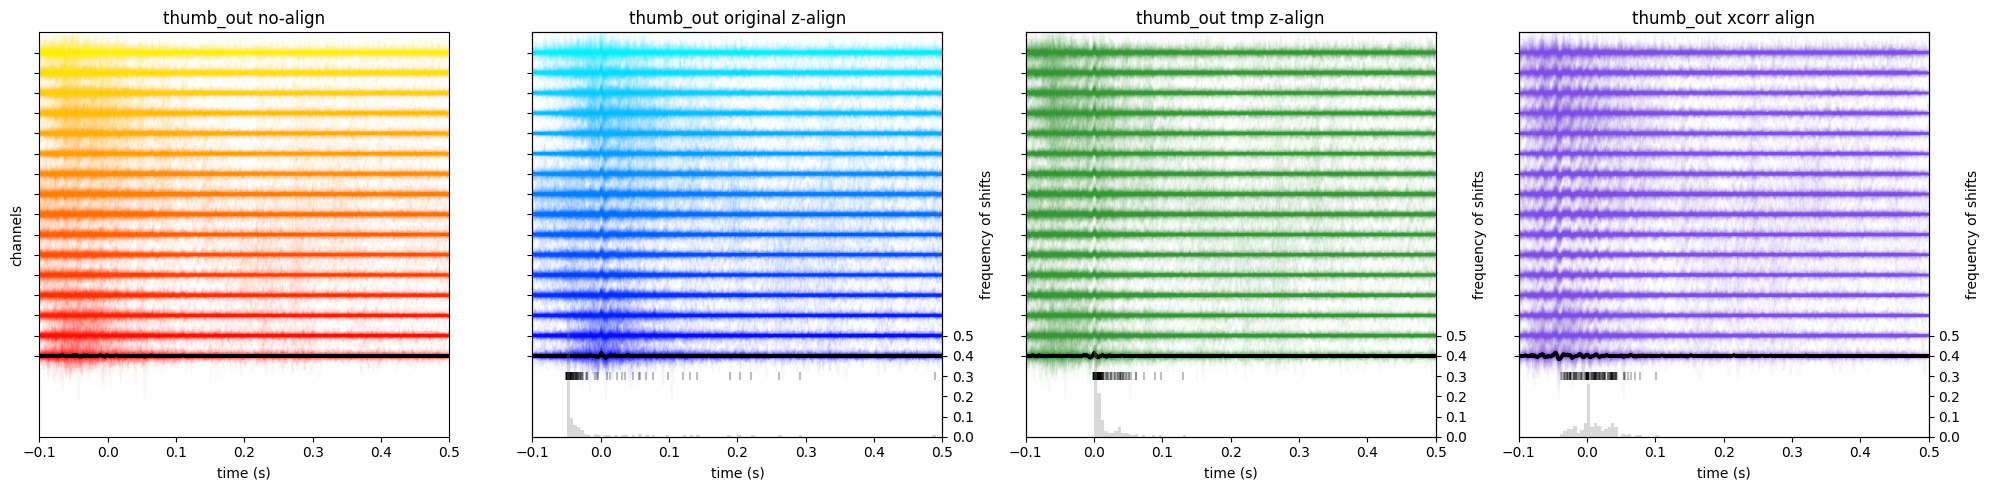

gesture     mode    n  mean_corr_to_ref  mean_std_over_time
0  thumb_out  noalign  150          0.076722            1.167635
1  thumb_out   orig_z  150          0.110465            1.191755
2  thumb_out    tmp_z  145          0.115751            1.172264
3  thumb_out    xcorr  150          0.203833            1.136564

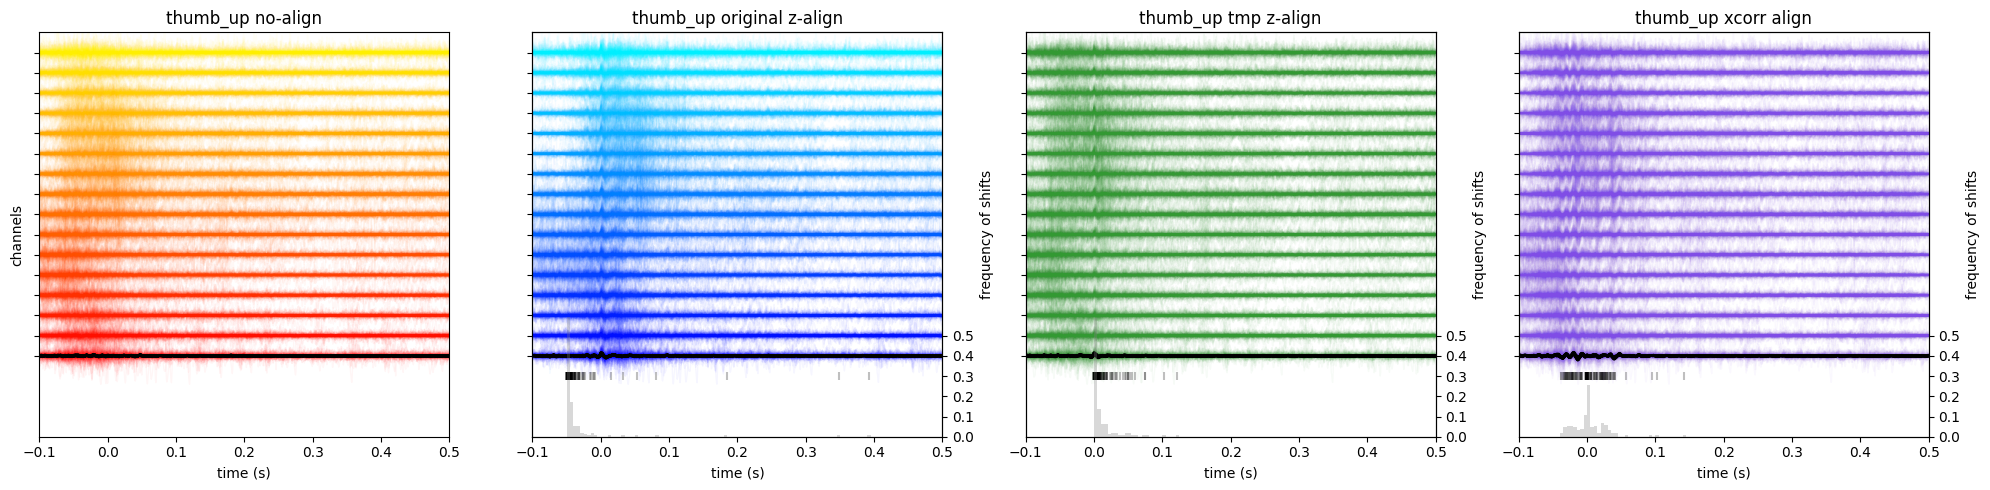

gesture     mode    n  mean_corr_to_ref  mean_std_over_time
0  thumb_up  noalign  150          0.078142            1.209065
1  thumb_up   orig_z  150          0.118442            1.230853
2  thumb_up    tmp_z  146          0.091635            1.218529
3  thumb_up    xcorr  150          0.186461            1.186025

BOX_DF shape: (36, 5)


In [1]:
# ====== 4-panel plots + per-gesture metrics (BOX_DF) ======
import os, sys, time, random, glob, gc, argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional
from numpy.typing import NDArray

# ----------- Config (edit these as needed) -----------
DATA_FOLDER   = "../../emg_data"
CORPUS_CSV    = os.path.join(DATA_FOLDER, "discrete_gestures_corpus.csv")
N_TRAIN_USERS = 40          # Total 80 TRAIN users
MAX_TRIALS_PER_GESTURE = 150
SEED = 13
CACHE_CSV = "box_df_cache.csv"   # for standalone/second cell fallback

# ----------- Constants -----------
SAMPLE_RATE = 2000  # Hz
VIEW_WIN_MS = (-100, 500)  # ms
VIEW_SMP    = (np.array(VIEW_WIN_MS)/1000.0) * SAMPLE_RATE
VIEW_SMP    = VIEW_SMP.astype(int)
TIME_REL    = np.arange(VIEW_SMP[0], VIEW_SMP[1]) / SAMPLE_RATE

SEARCH_WIN_ORIG = np.array([-.05, 1.5]) * SAMPLE_RATE  # samples

# tmp Z (from sweep)
TMP_Z_THR        = 2.5
TMP_Z_SEARCH_MS  = 160  # ms
TMP_Z_ONSET_CRIT = "any"

# XCorr baseline
XC_SEARCH_MS = 160   # ms
XC_ONSET_THR = 1.5
XC_MAX_LAG   = 80    # samples

# ----------- Loader (Meta repo) -----------
from generic_neuromotor_interface.explore_data.load import load_data

@dataclass
class Record:
    rec_id: int
    path: str
    user_number: int
    split: str
    time: NDArray[np.float64]
    emg: NDArray[np.float32]
    fs: float
    prompts_df: pd.DataFrame

@dataclass
class Trial:
    rec_id: int
    user_number: int
    split: str
    gesture: str
    t_prompt: float
    idx_prompt: int

def nearest_index(time_array: NDArray[np.float64], t: float, tol_sec: float) -> int:
    idx = np.searchsorted(time_array, t)
    cand = []
    if 0 <= idx < len(time_array): cand.append((abs(time_array[idx]-t), idx))
    if idx-1 >= 0: cand.append((abs(time_array[idx-1]-t), idx-1))
    if not cand: return -1
    tmp = min(cand, key=lambda z: z[0])
    return tmp[1] if tmp[0] <= tol_sec else -1

def load_train_recs_trials(data_folder: str, task_key: str, corpus_csv: str) -> Tuple[List[Record], List[Trial]]:
    df = pd.read_csv(corpus_csv)
    df["dataset_basename"] = df["dataset"].apply(lambda p: os.path.basename(p))
    files = [p for p in glob.glob(os.path.join(data_folder, "*.hdf5")) if task_key in os.path.basename(p)]
    keep = set(df[df["split"].str.lower()=="train"]["dataset_basename"])
    files = [f for f in files if os.path.basename(f) in keep]
    meta_map = {row["dataset_basename"]:(int(row["user_number"]), str(row["split"])) for _,row in df.iterrows()}
    recs = []
    for i, p in enumerate(sorted(files)):
        base = os.path.basename(p)
        if base not in meta_map: continue
        user_number, split = meta_map[base]
        d = load_data(p)
        fs = 1.0/np.median(np.diff(d.time))
        recs.append(Record(
            rec_id=i, path=p, user_number=user_number, split=split,
            time=d.time.astype(np.float64), emg=d.emg.astype(np.float32), fs=fs,
            prompts_df=d.prompts.copy()
        ))
    trials = []
    for r in recs:
        tol = 2.0 / r.fs
        dpf = r.prompts_df.sort_values("time").reset_index(drop=True)
        for _, row in dpf.iterrows():
            idx = nearest_index(r.time, float(row["time"]), tol)
            if idx >= 0:
                trials.append(Trial(
                    rec_id=r.rec_id, user_number=r.user_number, split=r.split,
                    gesture=str(row["name"]), t_prompt=float(row["time"]), idx_prompt=int(idx)
                ))
    return recs, trials

# ----------- Small helpers -----------
def zscore_global(emg: NDArray[np.float32]) -> NDArray[np.float32]:
    mu = emg.mean(axis=0, keepdims=True)
    sd = emg.std(axis=0, keepdims=True); sd[sd<1e-8]=1.0
    return (emg - mu)/sd

def slice_fixed(arr: NDArray[np.float32], center_idx: int, view_smp: NDArray[np.int64]) -> NDArray[np.float32]:
    a = int(center_idx + view_smp[0]); b = int(center_idx + view_smp[1])
    a = max(0, a); b = min(arr.shape[0], b)
    w = arr[a:b, :]
    L_target = int(view_smp[1]-view_smp[0])
    if w.shape[0] == L_target: return w
    if w.shape[0] <= 0:
        return np.zeros((L_target, arr.shape[1]), dtype=arr.dtype)
    if w.shape[0] > L_target:
        return w[:L_target, :]
    pad = np.zeros((L_target - w.shape[0], w.shape[1]), dtype=arr.dtype)
    return np.vstack([w, pad])

def find_onset_first_over(zwin: NDArray[np.float32], thr: float) -> Optional[int]:
    if zwin.size == 0: return None
    mx = np.max(zwin, axis=1)
    hits = np.where(mx > thr)[0]
    return int(hits[0]) if hits.size>0 else None

def xcorr_tmp_lag(trial: NDArray[np.float32], template: NDArray[np.float32], max_lag: int) -> int:
    W = min(trial.shape[0], template.shape[0])
    if W <= 1: return 0
    x = trial[:W,:]; h = template[:W,:]
    L = int(min(max_lag, W-1))
    if L <= 0: return 0
    lags = np.arange(-L, L+1)
    center = W-1
    acc = np.zeros(len(lags), dtype=np.float64)
    for ch in range(x.shape[1]):
        xc = np.correlate(x[:,ch], h[:,ch], mode='full')
        acc += xc[center-L:center+L+1]
    return int(lags[np.argmax(acc)])

def _metrics_from_windows(windows):
    if not windows:
        return {"n": 0, "mean_std_over_time": np.nan, "mean_corr_to_ref": np.nan}
    arr = np.stack(windows, axis=0)
    mean_wave = np.mean(arr, axis=0)
    std_over_trials = np.std(arr, axis=0)
    mean_std_over_time = float(np.mean(std_over_trials))
    cors = []
    for n in range(arr.shape[0]):
        ch_corrs = []
        for c in range(arr.shape[2]):
            a = arr[n, :, c]; b = mean_wave[:, c]
            sa = np.std(a); sb = np.std(b)
            if sa < 1e-8 or sb < 1e-8: continue
            ch_corrs.append(float(np.dot(a - a.mean(), b - b.mean()) / (len(a) * sa * sb)))
        if ch_corrs: cors.append(float(np.mean(ch_corrs)))
    return {"n": int(arr.shape[0]), "mean_std_over_time": mean_std_over_time,
            "mean_corr_to_ref": float(np.mean(cors)) if cors else np.nan}

# ----------- Main: Panels + build BOX_DF -----------
def plot_alignments_for_n_users(n_train_users: int = 3,
                                max_trials_per_gesture: int = 150,
                                seed: int = 13,
                                return_df: bool = True):
    """
    Plots 4 modes per gesture (noalign|orig_z|tmp_z|xcorr) for N TRAIN users,
    and optionally returns a tidy per-gesture DataFrame for boxplots.
    """
    random.seed(seed); np.random.seed(seed)

    recs, trials = load_train_recs_trials(DATA_FOLDER, "discrete_gestures", CORPUS_CSV)
    users_all = sorted({t.user_number for t in trials})
    if n_train_users <= 0 or n_train_users >= len(users_all):
        users_keep = users_all
    else:
        users_keep = users_all[:n_train_users]
    trials = [t for t in trials if t.user_number in users_keep]
    rec_idx_keep = {t.rec_id for t in trials}
    recs = [r for r in recs if r.rec_id in rec_idx_keep]

    z_by_rec = {r.rec_id: zscore_global(r.emg) for r in recs}

    by_gesture = defaultdict(list)
    for t in trials: by_gesture[t.gesture].append(t)
    gestures = [g for g,lst in by_gesture.items() if len(lst) >= 5]
    # for g in gestures:
    #     lst = by_gesture[g]
    #     random.shuffle(lst)
    #     by_gesture[g] = sorted(lst[:min(max_trials_per_gesture, len(lst))], key=lambda x: (x.user_number, x.idx_prompt))
    
    # New: sample up to max_trials_per_gesture_per_user per user
    MAX_TRIALS_PER_GESTURE_PER_USER = 30  # choose a reasonable number
    for g in gestures:
        lst = by_gesture[g]
        random.shuffle(lst)
        # group trials by user
        by_user = defaultdict(list)
        for t in lst:
            by_user[t.user_number].append(t)
        # sample per user
        lst_sampled = []
        for u, trials_user in by_user.items():
            n_take = min(MAX_TRIALS_PER_GESTURE_PER_USER, len(trials_user))
            lst_sampled.extend(trials_user[:n_take])
        # keep max total trials for the gesture (optional)
        lst_sampled = sorted(lst_sampled, key=lambda x: (x.user_number, x.idx_prompt))
        if len(lst_sampled) > MAX_TRIALS_PER_GESTURE:
            lst_sampled = lst_sampled[:MAX_TRIALS_PER_GESTURE]
        by_gesture[g] = lst_sampled
    
    # For the per-gesture DF
    rows = []

    for gesture in sorted(gestures):
        trials_g = by_gesture[gesture]
        if not trials_g: continue

        fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
        titles = [f"{gesture} non-aligned", f"{gesture} original z-align",
                  f"{gesture} tmp z-align", f"{gesture} xcorr align"]

        shifts_orig, shifts_tmp, shifts_xc = [], [], []

        # XCorr template from NoAlign mean
        template_xc = None
        if len(trials_g) > 0:
            wtmp = []
            for t in trials_g:
                z = z_by_rec[t.rec_id]
                wtmp.append(slice_fixed(z, t.idx_prompt, VIEW_SMP))
            template_xc = np.mean(np.stack(wtmp, axis=0), axis=0) if wtmp else None

        sum_noalign_z = sum_orig_z = sum_tmp_z = sum_xc_z = None
        n_noalign = n_orig = n_tmp = n_xc = 0

        # For DF windows
        noalign_windows = []
        orig_windows    = []
        tmp_windows    = []
        xc_windows      = []

        for i, t in enumerate(trials_g):
            z = z_by_rec[t.rec_id]

            # 1) No Align
            wz_no = slice_fixed(z, t.idx_prompt, VIEW_SMP)
            noalign_windows.append(wz_no)
            if sum_noalign_z is None: sum_noalign_z = np.zeros_like(wz_no)
            sum_noalign_z += wz_no; n_noalign += 1
            for ch in range(wz_no.shape[1]):
                alpha = (1/30 if gesture.startswith("thumb") else 1/255)
                axs[0].plot(TIME_REL, wz_no[:,ch] + 10*ch, color=(1,ch/16,0), linewidth=1, alpha=alpha)

            # 2) Original Z Align
            a = int(t.idx_prompt + SEARCH_WIN_ORIG[0]); b = int(t.idx_prompt + SEARCH_WIN_ORIG[1])
            a = max(0, a); b = min(z.shape[0], b)
            z_search = z[a:b, :]
            if z_search.shape[0] > 0:
                idx_local = np.where(np.max(z_search, axis=1) > 3.0)[0]
                if idx_local.size == 0:
                    idx_local = np.where(np.max(z_search, axis=1) > 1.65)[0]
                if idx_local.size > 0:
                    new_idx = a + int(idx_local[0])
                    shifts_orig.append(new_idx - t.idx_prompt)
                    wz_orig = slice_fixed(z, new_idx, VIEW_SMP)
                    orig_windows.append(wz_orig)
                    for ch in range(wz_orig.shape[1]):
                        alpha = (1/30 if gesture.startswith("thumb") else 1/255)
                        axs[1].plot(TIME_REL, wz_orig[:,ch] + 10*ch, color=(0,ch/16,1), linewidth=1, alpha=alpha)
                    if sum_orig_z is None: sum_orig_z = np.zeros_like(wz_orig)
                    sum_orig_z += wz_orig; n_orig += 1
                    axs[1].scatter((new_idx - t.idx_prompt)/SAMPLE_RATE, -10, marker='|', color='black', alpha=0.25)

            # 3) tmp Z Align (thr 2.5σ, search 0..160 ms)
            b2 = int(t.idx_prompt + (TMP_Z_SEARCH_MS/1000.0)*SAMPLE_RATE)
            b2 = min(z.shape[0], b2)
            z_search2 = z[t.idx_prompt:b2, :]
            if z_search2.shape[0] > 0:
                on2 = find_onset_first_over(z_search2, TMP_Z_THR)
                if on2 is not None:
                    new_idx2 = t.idx_prompt + int(on2)
                    shifts_tmp.append(new_idx2 - t.idx_prompt)
                    wz_tmp = slice_fixed(z, new_idx2, VIEW_SMP)
                    tmp_windows.append(wz_tmp)
                    for ch in range(wz_tmp.shape[1]):
                        alpha = (1/30 if gesture.startswith("thumb") else 1/255)
                        axs[2].plot(TIME_REL, wz_tmp[:,ch] + 10*ch, color=(0.2,0.6,0.2), linewidth=1, alpha=alpha)
                    if sum_tmp_z is None: sum_tmp_z = np.zeros_like(wz_tmp)
                    sum_tmp_z += wz_tmp; n_tmp += 1
                    axs[2].scatter((new_idx2 - t.idx_prompt)/SAMPLE_RATE, -10, marker='|', color='black', alpha=0.25)

            # 4) XCorr Align
            if template_xc is not None:
                b3 = int(t.idx_prompt + (XC_SEARCH_MS/1000.0)*SAMPLE_RATE)
                b3 = min(z.shape[0], b3)
                z_search3 = z[t.idx_prompt:b3, :]
                if z_search3.shape[0] > 0:
                    on3 = find_onset_first_over(z_search3, XC_ONSET_THR)
                    center = t.idx_prompt + (int(on3) if on3 is not None else 0)
                    wz_xc = slice_fixed(z, center, VIEW_SMP)
                    lag = xcorr_tmp_lag(wz_xc, template_xc, XC_MAX_LAG)
                    if lag > 0:
                        wz_xc_al = np.vstack([wz_xc[lag:, :], np.zeros((lag, wz_xc.shape[1]), dtype=wz_xc.dtype)])
                    elif lag < 0:
                        lagm = -lag
                        wz_xc_al = np.vstack([np.zeros((lagm, wz_xc.shape[1]), dtype=wz_xc.dtype), wz_xc[:lag, :]])
                    else:
                        wz_xc_al = wz_xc
                    shifts_xc.append((center - t.idx_prompt) + lag)
                    xc_windows.append(wz_xc_al)
                    for ch in range(wz_xc_al.shape[1]):
                        alpha = (1/30 if gesture.startswith("thumb") else 1/255)
                        axs[3].plot(TIME_REL, wz_xc_al[:,ch] + 10*ch, color=(0.5,0.3,0.9), linewidth=1, alpha=alpha)
                    if sum_xc_z is None: sum_xc_z = np.zeros_like(wz_xc_al)
                    sum_xc_z += wz_xc_al; n_xc += 1
                    axs[3].scatter(((center - t.idx_prompt)+lag)/SAMPLE_RATE, -10, marker='|', color='black', alpha=0.25)

        # overlay means
        if n_noalign>0: axs[0].plot(TIME_REL, (sum_noalign_z/n_noalign), color=(0,0,0), linewidth=2, alpha=1)
        if n_orig>0:    axs[1].plot(TIME_REL, (sum_orig_z/n_orig),    color=(0,0,0), linewidth=2, alpha=1)
        if n_tmp>0:    axs[2].plot(TIME_REL, (sum_tmp_z/n_tmp),    color=(0,0,0), linewidth=2, alpha=1)
        if n_xc>0:      axs[3].plot(TIME_REL, (sum_xc_z/n_xc),        color=(0,0,0), linewidth=2, alpha=1)

        # cosmetics + hist
        for k, ax in enumerate(axs):
            ax.set_yticks(np.arange(16)*10)
            if k == 0:
                ax.set_yticklabels(np.arange(16)); ax.set_ylabel('channels')
            else:
                ax.set_yticklabels([])
            ax.set_xlim(VIEW_SMP / SAMPLE_RATE); ax.set_ylim(-40, 160)
            ax.set_xlabel('time (s)'); ax.set_title(titles[k])

        bins = np.arange(VIEW_SMP[0], VIEW_SMP[1], 10)/SAMPLE_RATE
        if len(shifts_orig) > 0:
            ax1 = axs[1].twinx()
            ax1.hist(np.array(shifts_orig)/SAMPLE_RATE,
                     weights=np.ones(len(shifts_orig))/len(shifts_orig),
                     bins=bins, color='grey', alpha=0.3)
            ax1.set_ylim(0,2); ax1.set_yticks([0,0.1,0.2,0.3,0.4,0.5]); ax1.set_ylabel('frequency of shifts')
        if len(shifts_tmp) > 0:
            ax2 = axs[2].twinx()
            ax2.hist(np.array(shifts_tmp)/SAMPLE_RATE,
                     weights=np.ones(len(shifts_tmp))/len(shifts_tmp),
                     bins=bins, color='grey', alpha=0.3)
            ax2.set_ylim(0,2); ax2.set_yticks([0,0.1,0.2,0.3,0.4,0.5]); ax2.set_ylabel('frequency of shifts')
        if len(shifts_xc) > 0:
            ax3 = axs[3].twinx()
            ax3.hist(np.array(shifts_xc)/SAMPLE_RATE,
                     weights=np.ones(len(shifts_xc))/len(shifts_xc),
                     bins=bins, color='grey', alpha=0.3)
            ax3.set_ylim(0,2); ax3.set_yticks([0,0.1,0.2,0.3,0.4,0.5]); ax3.set_ylabel('frequency of shifts')

        plt.tight_layout(); plt.show(); gc.collect()

        # ---- per-gesture metrics rows for BOX_DF ----
        # same metric as elsewhere (mean_corr_to_ref ↑ better; mean_std_over_time ↓ better)
        gesture_rows = []
        for mname, wins in [("noalign", noalign_windows),
                            ("orig_z", orig_windows),
                            ("tmp_z", tmp_windows),
                            ("xcorr", xc_windows)]:
            m = _metrics_from_windows(wins)
            row = {"gesture": gesture, "mode": mname,
                   "n": m["n"],
                   "mean_corr_to_ref": m["mean_corr_to_ref"],
                   "mean_std_over_time": m["mean_std_over_time"]}
            rows.append(row)        # full BOX_DF accumulation
            gesture_rows.append(row) # per-gesture display
        
        # display the per-gesture table under the plots
        import IPython.display as display_ipy
        display_ipy.display(pd.DataFrame(gesture_rows))
    
    # ---- after all gestures, build full BOX_DF ----
    box_df = pd.DataFrame(rows)
    # cache to disk so a second cell can load it even if kernel is reset
    try:
        box_df.to_csv(CACHE_CSV, index=False)
    except Exception as e:
        print("[warn] could not cache BOX_DF to disk:", e)
    
    return box_df
        
# ----------- Run `plot_alignments_for_n_users` -----------
BOX_DF = plot_alignments_for_n_users(n_train_users=N_TRAIN_USERS,
                                     max_trials_per_gesture=MAX_TRIALS_PER_GESTURE,
                                     seed=SEED,
                                     return_df=True)

print("BOX_DF shape:", BOX_DF.shape)

## Barplots: alignment methods

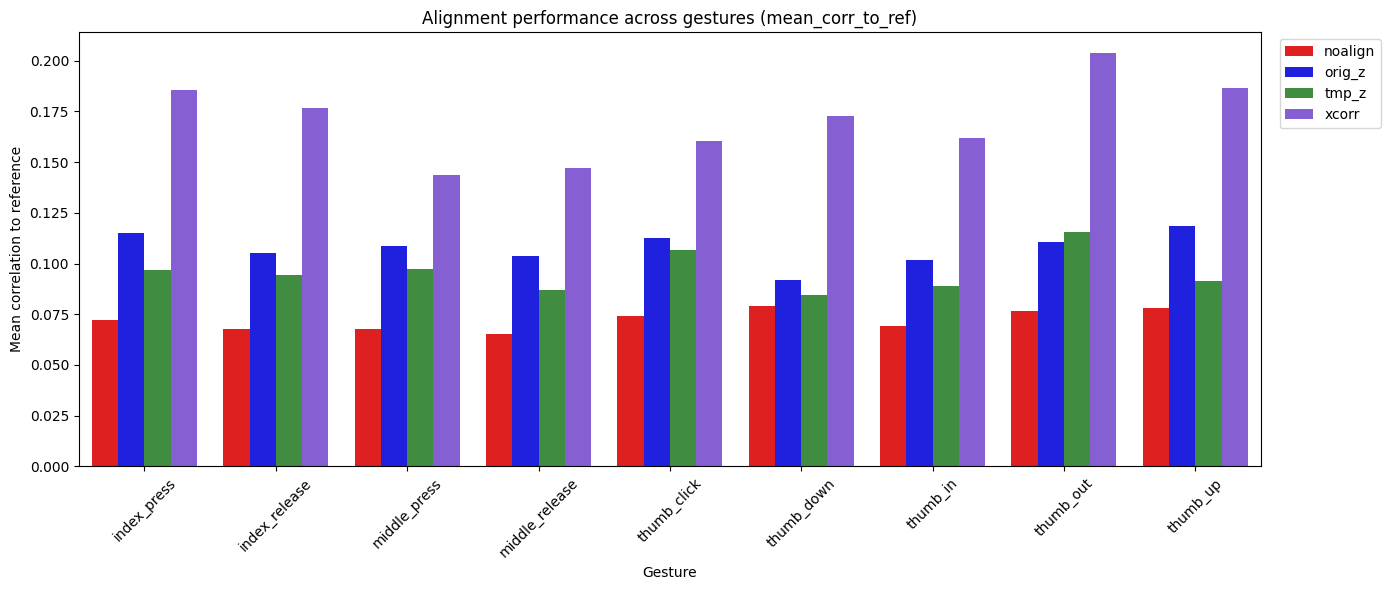

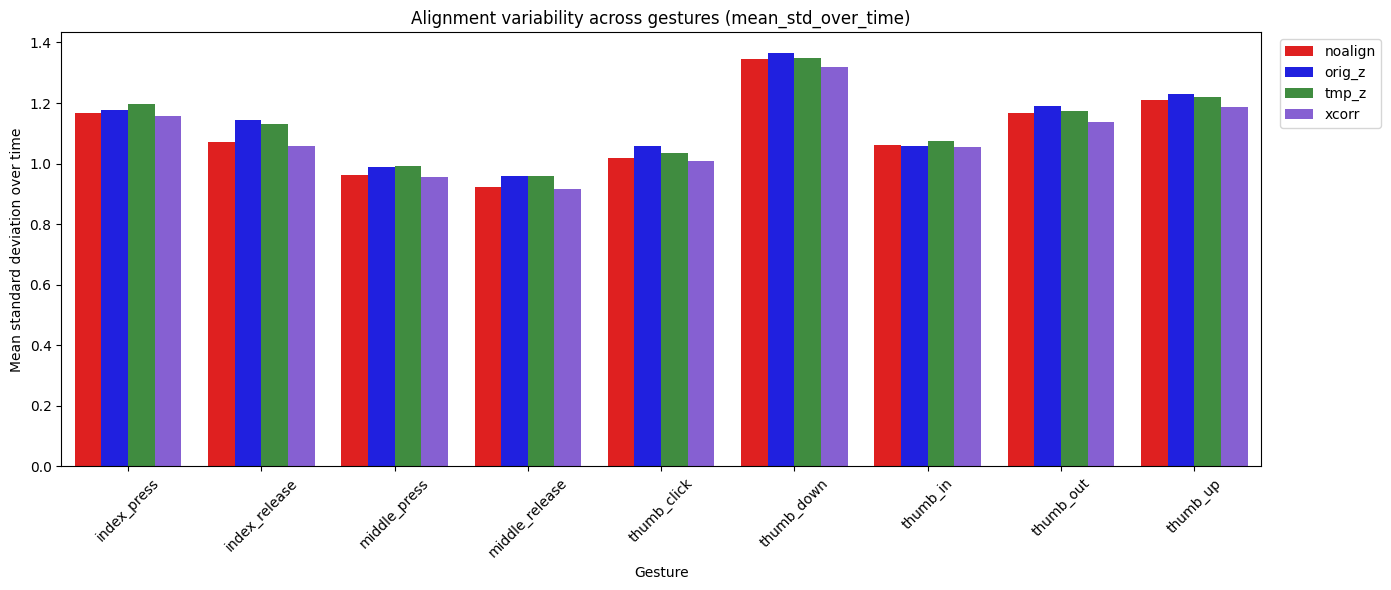

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Aggregate per gesture & mode for correlation
agg_corr = BOX_DF.groupby(['gesture','mode'])['mean_corr_to_ref'].agg(['mean','std']).reset_index()

# Aggregate per gesture & mode for standard deviation over time
agg_std = BOX_DF.groupby(['gesture','mode'])['mean_std_over_time'].agg(['mean','std']).reset_index()

colors = {
    'noalign': (1,0,0),       # red
    'orig_z': (0,0,1),        # blue
    'tmp_z': (0.2,0.6,0.2),   # green
    'xcorr': (0.5,0.3,0.9)    # purple
}

# ---- Barplot for mean correlation to reference ----
plt.figure(figsize=(14,6))
ax1 = sns.barplot(
    data=agg_corr,
    x='gesture',
    y='mean',
    hue='mode',
    palette=colors,
    errorbar=None,
    err_kws={'yerr': agg_corr['std'].values, 'color': 'black', 'linewidth': 1.5}
)
ax1.set_ylabel('Mean correlation to reference')
ax1.set_xlabel('Gesture')
plt.xticks(rotation=45)
plt.title('Alignment performance across gestures (mean_corr_to_ref)')

# Move legend to the right
ax1.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
plt.tight_layout()
plt.show()

# ---- Barplot for mean standard deviation over time ----
plt.figure(figsize=(14,6))
ax2 = sns.barplot(
    data=agg_std,
    x='gesture',
    y='mean',
    hue='mode',
    palette=colors,
    errorbar=None,
    err_kws={'yerr': agg_std['std'].values, 'color': 'black', 'linewidth': 1.5}
)
ax2.set_ylabel('Mean standard deviation over time')
ax2.set_xlabel('Gesture')
plt.xticks(rotation=45)
plt.title('Alignment variability across gestures (mean_std_over_time)')

# Move legend to the right
ax2.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
plt.tight_layout()
plt.show()